In [1]:
import pandas as pd
from py2neo import Graph
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import time

In [70]:
googleDrive = False
if googleDrive:
    #Adding via Google Drive...make sure you give the right directory.
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv("/content/drive/MyDrive/IMDB_Top250Engmovies2_OMDB_Detailed.csv")
else:
    #Adding the dataset Manually into the runtime
    df = pd.read_csv('./DataSet/IMDB_Top250Engmovies2_OMDB_Detailed.csv')
df.head()
len(df.columns)



38

In [66]:
cols_to_drop = [3,4,5,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]
df.drop(df.columns[cols_to_drop],axis=1, inplace = True)
df.head()


IndexError: index 10 is out of bounds for axis 0 with size 8

In [69]:
df.columns.to_list()

['Index', 'Title', 'Year', 'Genre', 'Director', 'Writer', 'Actors', 'Rating']

In [6]:
df.rename(columns={'Unnamed: 0':'Index','imdbRating':'Rating'},inplace = True)
df.head()

,Index,Title,Year,Genre,Director,Writer,Actors,Rating
0,1,The Shawshank Redemption,1994,"Crime, Drama",Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",9.3
1,2,The Godfather,1972,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay), Francis Ford Coppola ...","Marlon Brando, Al Pacino, James Caan, Richard ...",9.2
2,3,The Godfather: Part II,1974,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay), Mario Puzo ...","Al Pacino, Robert Duvall, Diane Keaton, Robert...",9.0
3,4,The Dark Knight,2008,"Action, Crime, Drama",Christopher Nolan,"Jonathan Nolan (screenplay), Christopher Nolan...","Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0
4,5,12 Angry Men,1957,"Crime, Drama",Sidney Lumet,"Reginald Rose (story), Reginald Rose (screenplay)","Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",8.9


##Connection details as per System

In [44]:
#Please add your connection details here.
isSandbox = False
if isSandbox:
    ip="3.92.182.226"
    port="7474"
    pwd="particles-arcs-automobile"
    graph = Graph("bolt://3.92.182.226:7687", auth=("neo4j", pwd))
else:
    pwd="root"
    graph = Graph("bolt://localhost:7687", auth=("neo4j", pwd ))


## Loding Data

In [9]:
LOAD_DATA = True

def run_request(request,LOAD_DATA):
    if (LOAD_DATA):
        start_time = time.time()
        print(graph.run(request)) 
        exec_time = time.time() - start_time
        print(f'-- {exec_time} seconds --')

## Deleting Old Data

In [ ]:
request_delete ="""
MATCH (n) DETACH DELETE n;
"""
run_request(request_delete,LOAD_DATA)

(No data)
-- 0.5876979827880859 seconds --


## Creating Movies Nodes

In [10]:
# Creating a reqest String 
request ="""
CREATE (m:Movie {id:$index,name: $Movie_Name})
SET 
m.directors = $director,
m.Year = $year, 
m.rating = $rating,
m.cast=$cast,
m.writers = $writer,
m.genre = $genre
"""
start_time = time.time()
count=df.shape[0]
if (LOAD_DATA):
  for index, row in df.iterrows():
    graph.run(request,
              index=row['Index'],
              Movie_Name=row['Title'],
              director=None if pd.isnull(row['Director']) else row['Director'],
              year= None if pd.isnull(row['Year']) else row['Year'],
              rating=None if pd.isnull(row['Rating']) else row['Rating'],          
              cast= None if pd.isnull(row['Actors']) else row['Actors'],
              writer=None if pd.isnull(row['Writer']) else row['Writer'],
              genre = None if pd.isnull(row['Genre']) else row['Genre']
              )
    if (index%50==0):
        exec_time = time.time()- start_time
        print(f'{index}/{df.shape[0]} done ... -- {exec_time} seconds --')
    
  exec_time = time.time()- start_time
  print(f' ... End ... -- {exec_time} seconds --') 

0/250 done ... -- 0.6789305210113525 seconds --
50/250 done ... -- 1.2568213939666748 seconds --
100/250 done ... -- 1.7631525993347168 seconds --
150/250 done ... -- 2.229919672012329 seconds --
200/250 done ... -- 2.7316160202026367 seconds --
 ... End ... -- 3.1800355911254883 seconds --


## Creating Persons->Actor

In [11]:
request ="""
MATCH (m:Movie)
WHERE m.cast IS NOT NULL
WITH m
UNWIND split(m.cast, ',') AS actor
MERGE (p:Person {name: trim(actor)})
MERGE (p)-[r:ACTED_IN]->(m);
"""    
run_request(request,LOAD_DATA)

(No data)
-- 0.8255393505096436 seconds --


## Creating Person->Director

In [12]:
request =""" 
MATCH (m:Movie)
WHERE m.directors IS NOT NULL
WITH m
MERGE (d:Person {name: m.directors})
MERGE (d)-[r:DIRECTED]->(m);
"""
run_request(request,LOAD_DATA) 

(No data)
-- 0.4446096420288086 seconds --


## Creating Movie->Genre

In [13]:
request ="""    
MATCH (m:Movie)
WHERE m.genre IS NOT NULL
WITH m
UNWIND split(m.genre, ',') AS category
MERGE (c:Genre {name: trim(category)})
MERGE (m)-[r:Genre]->(c);
"""    
run_request(request,LOAD_DATA)

(No data)
-- 0.24243402481079102 seconds --


## Creating Actor->Movie<-Actor Relationship

In [14]:
request = """
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person)
MERGE (p)-[r:WORK_WITH]-(p2);
"""
run_request(request,LOAD_DATA) 

(No data)
-- 1.6558709144592285 seconds --


## Creating Year Relations

In [15]:
request="""
CREATE INDEX ON :Year(value);
"""
run_request(request,LOAD_DATA)

(No data)
-- 0.19932270050048828 seconds --


In [16]:
request="""
WITH range(1997, 2019) AS years, range(1,12) AS months
FOREACH(year IN years |
  CREATE (y:Year {value: year}));
"""
run_request(request,LOAD_DATA)

(No data)
-- 0.13647985458374023 seconds --


In [17]:
request="""
MATCH (year:Year)
WITH year
ORDER BY year.value
WITH collect(year) AS years
FOREACH(i in RANGE(0, size(years)-2) |
    FOREACH(year1 in [years[i]] |
        FOREACH(year2 in [years[i+1]] |
            MERGE (year1)-[:NEXT]->(year2))));
"""
run_request(request,LOAD_DATA)

(No data)
-- 0.28383564949035645 seconds --


In [18]:
request="""
MATCH (m:Movie)
WITH m, m.Year AS y
MATCH (year:Year{value:y})
MERGE (m)-[:CREATED_ON]->(year)
RETURN m,year;
"""
run_request(request,LOAD_DATA)

 m                                                                                                                                                                                                                                                                                                                                                         | year                       
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------
 (_3:Movie {Year: 2008, cast: 'Christian Bale, Heath Ledger, Aaron Eckhart, Michael Caine', directors: 'Christopher Nolan', genre: 'Action, Crime, Drama', id: 4, name: 'The Dark Knight', rating: 9.0, writers: 'Jonathan Nolan (screenplay), Christo

## Useful

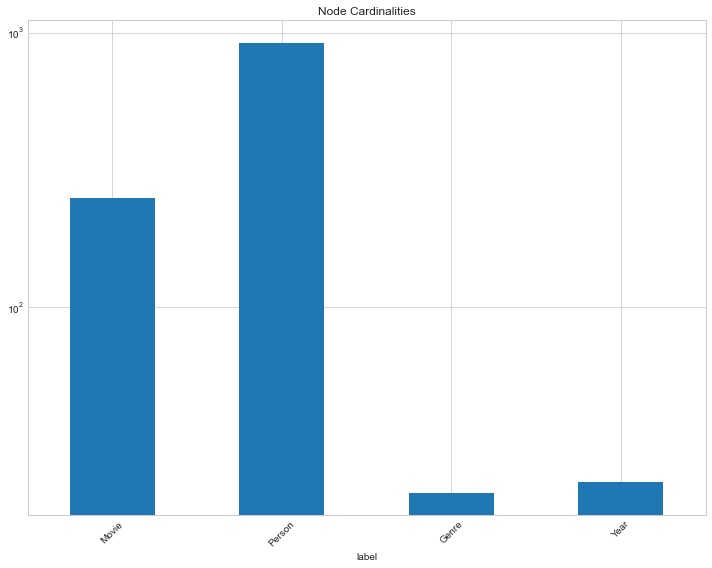

In [19]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities",figsize=(10,8))
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

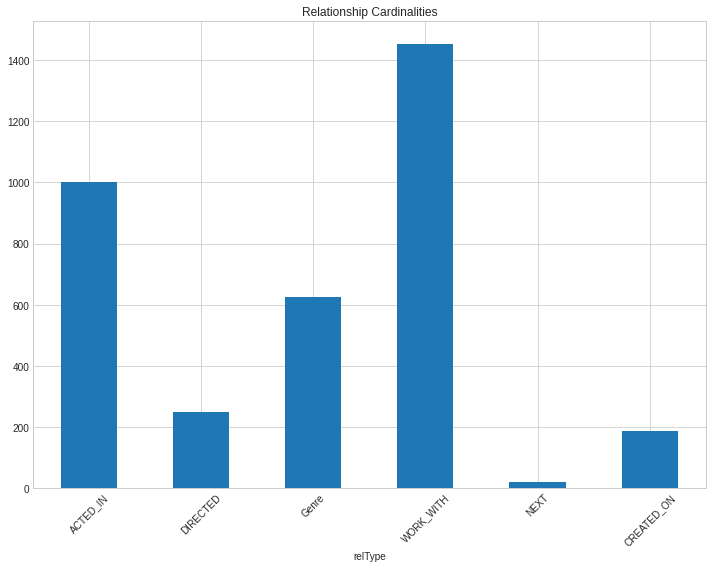

In [ ]:
# Relations Ship Cardinalities
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities",figsize=(10,8))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

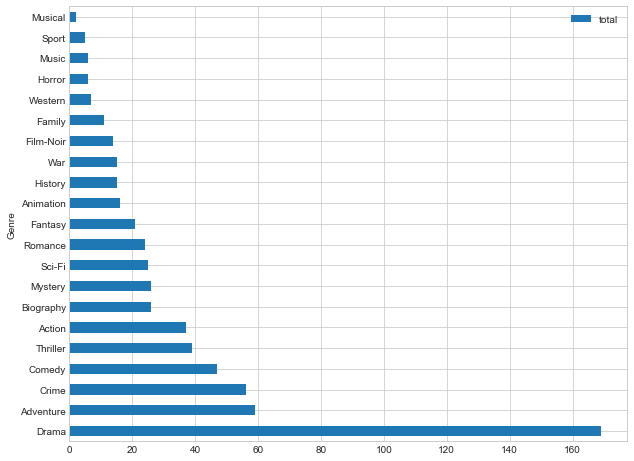

In [20]:
request="""
MATCH (c:Genre)<-[rel:Genre]-(m:Movie)
WITH c.name as Genre,count(*) as total
RETURN  Genre,total
ORDER BY total DESC
"""
result = graph.run(request).to_data_frame()
result.plot.barh(x='Genre', y='total',figsize=(10,8))
plt.show()

In [ ]:
request_top_5_actor="""
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)
WITH p,collect(m.name) as movies,count(*) as total
RETURN  p.name as Actor, movies As Movies_Acted_In,total As Total_Movies
ORDER BY total DESC
LIMIT 5
"""
graph.run(request_top_5_actor).to_data_frame().head()

,Actor,Movies_Acted_In,Total_Movies
0,Leonardo DiCaprio,"[Inception, The Departed, Django Unchained, Th...",8
1,James Stewart,"[It's a Wonderful Life, Rear Window, Vertigo, ...",7
2,Robert De Niro,"[The Godfather: Part II, Goodfellas, Once Upon...",7
3,Harrison Ford,[Star Wars: Episode V - The Empire Strikes Bac...,7
4,Tom Hanks,"[Forrest Gump, Saving Private Ryan, The Green ...",6


In [21]:
def who_be_present(I_AM,I_WANT_TO_MEET):
    print(f"I'm {I_AM}")
    print(f"I want to meet {I_WANT_TO_MEET}")
    request="""
    MATCH (cs:Person { name: $pfrom }),(ms:Person { name: $pto }), p = shortestPath((cs)-[:ACTED_IN|DIRECTED*]-(ms))
    WHERE length(p)> 1 
    RETURN p
    """
    cursor = graph.run(request,pfrom=I_AM,pto=I_WANT_TO_MEET)
    while cursor.forward():
        print(cursor['p'])
    print('\n')
        
        
I_AM='Leonardo DiCaprio'
I_WANT_TO_MEET='Brad Pitt'
who_be_present(I_AM,I_WANT_TO_MEET)

I_AM='Charles Chaplin'
I_WANT_TO_MEET='Virginia Cherrill'
who_be_present(I_AM,I_WANT_TO_MEET)

I'm Leonardo DiCaprio
I want to meet Brad Pitt
(Leonardo DiCaprio)-[:ACTED_IN {}]->(Django Unchained)<-[:ACTED_IN {}]-(Christoph Waltz)-[:ACTED_IN {}]->(Inglourious Basterds)<-[:ACTED_IN {}]-(Brad Pitt)


I'm Charles Chaplin
I want to meet Virginia Cherrill
(Charles Chaplin)-[:DIRECTED {}]->(City Lights)<-[:ACTED_IN {}]-(Virginia Cherrill)




In [83]:
request_link_prediction_movie="""
MATCH (a:Movie {name:$ptitle} )-[*4]-(b:Movie)
WHERE a <> b AND a.name < b.name
WITH DISTINCT a,b
RETURN a.name as title, b.name as recommendation, gds.alpha.linkprediction.adamicAdar(a, b) AS score
ORDER BY score DESC
LIMIT 10
"""
recommend_df = graph.run(request_link_prediction_movie,ptitle="Inception").to_data_frame()
# recommend_df.to_csv("recommend.csv")
recommend_df
# print(graph.run(request_link_prediction_movie,ptitle="Once Upon a Time in America").to_data_frame())

,title,recommendation,score
0,Inception,The Dark Knight Rises,1.650711
1,Inception,Mad Max: Fury Road,1.178828
2,Inception,Interstellar,1.069812
3,Inception,The Revenant,0.882429
4,Inception,Spider-Man: Homecoming,0.832851
5,Inception,The Prestige,0.824566
6,Inception,Shutter Island,0.805105
7,Inception,The Dark Knight,0.790836
8,Inception,Toy Story 3,0.759144
9,Inception,Warrior,0.622914


In [ ]:
request_link_prediction_movie="""
MATCH (a:Movie {name:$ptitle} )-[*4]-(b:Movie)
WHERE a <> b AND a.name < b.name
WITH DISTINCT a,b
RETURN a.name as title, b.name as recommendation, gds.alpha.linkprediction.adamicAdar(a, b) AS score
ORDER BY score DESC
LIMIT 10
"""
recommend_df = graph.run(request_link_prediction_movie,ptitle="Inception").to_data_frame()
recommend_df

In [57]:
named_graph="""
CALL gds.graph.create(
  'MovieDirectedGraphy',
  'Person',
  'DIRECTED'
);
"""
print(graph.run(named_graph).to_data_frame())

                                      nodeProjection  \
0  {'Person': {'label': 'Person', 'properties': {}}}   

                              relationshipProjection            graphName  \
0  {'DIRECTED': {'orientation': 'NATURAL', 'aggre...  MovieDirectedGraphy   

   nodeCount  relationshipCount  createMillis  
0        917                  0           100  


In [32]:
named_graph="""
CALL gds.graph.create(
  'MovieActedGraph',
  'Person',
  'ACTED_IN'
);
"""
print(graph.run(named_graph).to_data_frame())

                                      nodeProjection  \
0  {'Person': {'label': 'Person', 'properties': {}}}   

                              relationshipProjection        graphName  \
0  {'ACTED_IN': {'orientation': 'NATURAL', 'aggre...  MovieActedGraph   

   nodeCount  relationshipCount  createMillis  
0        917                  0            19  


In [45]:
named_graphWrk="""
CALL gds.graph.create(
  'MovieWorkGraph',
  'Person',
  'WORK_WITH'
);
"""
print(graph.run(named_graphWrk).to_data_frame())

                                      nodeProjection  \
0  {'Person': {'label': 'Person', 'properties': {}}}   

                              relationshipProjection       graphName  \
0  {'WORK_WITH': {'orientation': 'NATURAL', 'aggr...  MovieWorkGraph   

   nodeCount  relationshipCount  createMillis  
0        917               1454           149  


In [33]:
page_rank="""
CALL gds.pageRank.write('MovieDirectedGraphy', {
  maxIterations: 20,
  dampingFactor: 0.85,
  writeProperty: 'pagerank'
})
YIELD nodePropertiesWritten, ranIterations;
"""
print(graph.run(page_rank).to_data_frame())

   nodePropertiesWritten  ranIterations
0                    917              1


In [34]:
page_rank="""
CALL gds.pageRank.write('MovieActedGraph', {
  maxIterations: 20,
  dampingFactor: 0.85,
  writeProperty: 'pagerank'
})
YIELD nodePropertiesWritten, ranIterations;
"""
print(graph.run(page_rank).to_data_frame())

   nodePropertiesWritten  ranIterations
0                    917              1


In [42]:
closeness_act="""
CALL gds.alpha.closeness.write({
  nodeProjection: 'Person',
  relationshipProjection: 'WORK_WITH',
  writeProperty: 'ActClose'
}) YIELD nodes, writeProperty;
"""
print(graph.run(closeness_act).to_data_frame())

   nodes writeProperty
0    917      ActClose


In [48]:
community_detect="""
CALL gds.labelPropagation.stream('MovieWorkGraph')
YIELD nodeId, communityId AS Community
RETURN gds.util.asNode(nodeId).name AS Name, Community
ORDER BY Community, Name
"""
com_val = graph.run(community_detect).to_data_frame()

array([ 253,  257,  268,  272,  276,  280,  290,  300,  303,  305,  312,
        317,  322,  334,  337,  341,  348,  352,  355,  361,  365,  370,
        374,  383,  391,  399,  409,  417,  421,  429,  433,  440,  446,
        449,  453,  457,  461,  464,  471,  479,  482,  484,  491,  493,
        501,  505,  509,  511,  520,  527,  531,  532,  537,  541,  543,
        547,  548,  550,  560,  562,  565,  573,  578,  585,  589,  591,
        609,  614,  618,  619,  622,  625,  627,  638,  640,  654,  656,
        662,  672,  677,  684,  688,  691,  695,  702,  704,  707,  711,
        714,  720,  721,  724,  730,  737,  741,  743,  752,  755,  758,
        761,  762,  767,  771,  772,  773,  790,  793,  794,  800,  802,
        806,  810,  813,  816,  818,  824,  829,  835,  844,  850,  854,
        858,  862,  864,  868,  872,  878,  880,  884,  885,  889,  896,
        898,  903,  907,  910,  912,  917,  919,  922,  926,  929,  933,
        939,  942,  946,  956,  959,  965,  969,  9

In [58]:
community_detect="""
CALL gds.labelPropagation.stream('MovieDirectedGraphy')
YIELD nodeId, communityId AS Community
RETURN gds.util.asNode(nodeId).name AS Name, Community
ORDER BY Community, Name
"""
com_val = graph.run(community_detect).to_data_frame()

In [71]:
len(com_val)

917

In [72]:
created_on_graph="""
CALL gds.graph.create(
  'MovieYear',
  'Year',
  'CREATED_ON'
);
"""
print(graph.run(created_on_graph).to_data_frame())

                                  nodeProjection  \
0  {'Year': {'label': 'Year', 'properties': {}}}   

                              relationshipProjection  graphName  nodeCount  \
0  {'CREATED_ON': {'orientation': 'NATURAL', 'agg...  MovieYear         23   

   relationshipCount  createMillis  
0                  0            20  


In [73]:
year_community_detect="""
CALL gds.labelPropagation.stream('MovieYear')
YIELD nodeId, communityId AS Community
RETURN gds.util.asNode(nodeId).name AS Name, Community
ORDER BY Community, Name
"""
com_val = graph.run(year_community_detect).to_data_frame()

In [79]:
com_val.drop_duplicates

<bound method DataFrame.drop_duplicates of     Name  Community
0   None       1188
1   None       1189
2   None       1190
3   None       1191
4   None       1192
5   None       1193
6   None       1194
7   None       1195
8   None       1196
9   None       1197
10  None       1198
11  None       1199
12  None       1200
13  None       1201
14  None       1202
15  None       1203
16  None       1204
17  None       1205
18  None       1206
19  None       1207
20  None       1208
21  None       1209
22  None       1210>

In [80]:
com_val

,Name,Community
0,None,1188
1,None,1189
2,None,1190
3,None,1191
4,None,1192
5,None,1193
6,None,1194
7,None,1195
8,None,1196
9,None,1197
